<a href="https://colab.research.google.com/github/bella-xia/Medical_Image/blob/main/img_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [ ]:
from pickle import dump, load

In [ ]:
import cv2

# Load Data

In [ ]:
img_list = [0, 2, 3, 7, 8, 11, 18, 20, 22, 28, 30, 34, 35, 37, 38, 39, 44, 45, 46]

In [ ]:
print(len(img_list))

19


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Medical Image/data/df_100.h5', 'rb') as f:
  df = load(f)

In [ ]:
df.head()

,extent_right_numerical,density_right_numerical,extent_left_numerical,density_left_numerical,mRALE Score,img
0,4,3,4,2,20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,3,3,3,2,15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,1,1,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
imgs = df.iloc[img_list]['img'].tolist()

In [ ]:
print(len(imgs))

19


In [ ]:
def show_imgs(imgs, img_list):
  length = len(imgs)
  columns = 5
  rows = length // 5 + 1
  fig = plt.figure(figsize=(columns * 2, rows * 2))
  for i in range(length):
    img = imgs[i]
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(img, 'gray')
    ax.title.set_text(f'Image # {img_list[i]}')
    ax.axis('off')

  plt.show()

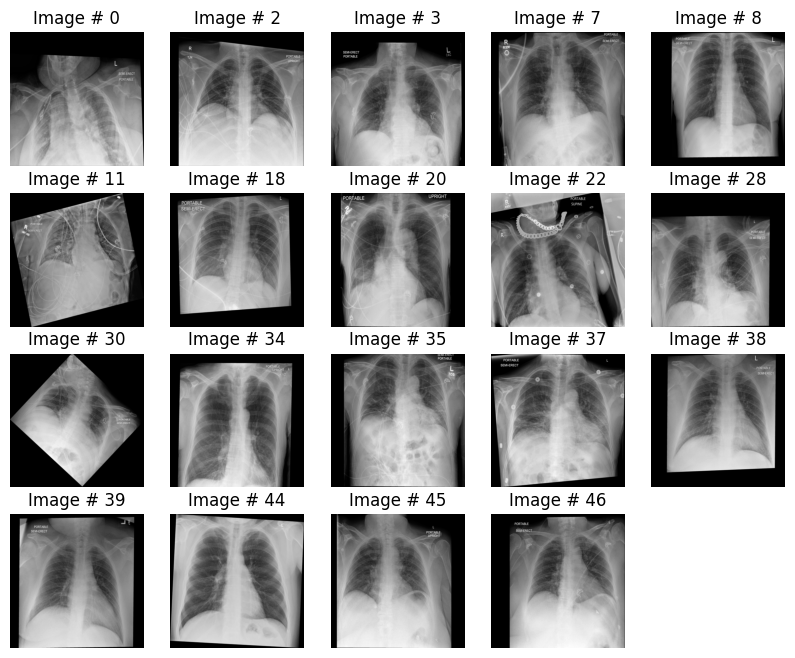

In [ ]:
show_imgs(imgs, img_list)

In [ ]:
def get_blacks(img, rows, cols):
  img = img.reshape((rows, cols))
  points = []
  for i in range(rows):
    check = False
    point = []
    img_slice = img[i, :]
    for j in range(cols):
      if img_slice[j] == 0 and check is False:
        point.append(j)
        check = True
      elif (img_slice[j] == 0 and j == cols - 1) or (img_slice[j] != 0 and check is True):
        if j - 1 - point[-1] < 10:
          point = point[:-1]
        else:
          point.append(j - 1)
        check = False
    points.append(check_arr(point, cols))
#     points.append(point)
  return np.array(points, dtype=np.int32)

In [ ]:
def check_arr(point, cols):
  if len(point) > 4:
    point = point[:2] + point[-2:]
  if len(point) == 2 and point[0] >= 10 and cols - 1 - point[-1] >= 10:
    point = []
  if len(point) > 2:
    if point[0] >= 10:
      point = point[:2]
    if len(point) >= 2 and cols - 1 - point[-1] >= 10:
      point = point[:-2]
  if len(point) <= 1:
    return [0, 0, 0, 0]
  elif len(point) <= 3 :
    return (point[:2] + [0, 0] if point[0] < 10
            else [0, 0] + point[-2:])
  else:
    return point

In [ ]:
def FindRec(points, cols):
  rows = points.shape[0]
  # first identify rectangles on all sides
  left = points[:, :2]
  left_length = left[:, 1] - left[:, 0]
  left_length = left_length.reshape((left.shape[0],))
  right = points[:, 2:]
  right_length = right[:, 1] - right[:, 0]
  right_length = right_length.reshape((right.shape[0],))

  # top
  if cols - 1 - left_length[0] < 10 or cols - 1 - right_length[0] < 10:
    top_width = 9
    while (cols - 1 - left_length[top_width] < 10) or (cols - 1 - right_length[top_width] < 10):
      top_width += 1
  else:
    top_width = 0

  # bottom
  if cols - 1 - left_length[rows - 1] < 10 or cols - 1 - right_length[rows - 1] < 10:
    bottom_width = 0
    while (cols - 1 - left_length[rows - 1 - bottom_width] < 10) or (cols - 1 - right_length[rows - 1 - bottom_width] < 10):
      bottom_width += 1
    bottom_width = rows - bottom_width
  else:
    bottom_width = rows

  # left
  if abs(left_length[rows // 5:rows - 1 - rows // 5].mean() - left_length[rows // 5]) < 20 and abs(
      left_length[rows // 5:rows - 1 - rows // 5].mean() - left_length[rows - 1 - rows // 5]) < 20:
    left_width = int(left_length.mean())
  else:
    left_width = 0

  # right
  if abs(right_length[rows // 5:rows - 1 - rows // 5].mean() - right_length[rows // 5]) < 20 and abs(
      right_length[rows // 5:rows - 1 - rows // 5].mean() - right_length[rows - 1 - rows // 5]) < 20:
    right_width = cols - int(right_length.mean())
  else:
    right_width = cols

  return top_width, bottom_width, left_width, right_width

In [ ]:
def CropRec(img, points):
  top_width, bottom_width, left_width, right_width = FindRec(points, img.shape[1])
  return img[top_width:bottom_width, left_width:right_width], points[top_width:bottom_width]

In [ ]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(src=image, M=M, dsize=(w, h))

    return rotated

In [ ]:
def getRotation(img, points):
  rows = points.shape[0]
  left = points[:, :2]
  left_length = left[:, 1] - left[:, 0]
  left_length = left_length.reshape((left.shape[0],))
  right = points[:, 2:]
  right_length = right[:, 1] - right[:, 0]
  right_length = right_length.reshape((right.shape[0],))

  top_width = left_length[5]
  top_height = 0
  for i in range(rows):
    if left_length[i] < 20:
      top_height = i
      break

  bottom_width = left_length[rows - 1 - 5]
  bottom_height = rows - top_height

  rim = max(math.sqrt(math.pow(bottom_width, 2) + math.pow(bottom_height, 2)),
            math.sqrt(math.pow(top_width, 2) + math.pow(top_height, 2)))
  scale = rows / rim

  top_angle = math.atan(top_width / top_height) if top_height != 0 else 0
  bottom_angle = math.atan(bottom_height / bottom_width) if bottom_width != 0 else 0
  rotated = False

  if (abs(top_angle - bottom_angle) < 0.2):
    rotated = True
    angle = (top_angle + bottom_angle) / 2
    # if angle smaller than 50 degrees, rotate counterclockwise
    if angle < 0.9:
      img = rotate(img, angle / math.pi * 180, scale=scale)
    # if angle larger than 50 degrees, rotate clockwise
    else:
      img = rotate(img, angle / math.pi * 180 - 90, scale=scale)

  return img, rotated


In [ ]:
def Process(img, rows=512, cols=512):
  points = get_blacks(img, rows, cols)
  img_cropped, points_cropped = CropRec(img, points)
  img_rotated, rotated = getRotation(img_cropped, points_cropped)
  img_rotated = cv2.resize(img_rotated, (rows, cols))

  return img_rotated

In [ ]:
def show_imgs_preprocessed(imgs, img_list):
  length = len(imgs)
  columns = 5
  rows = length // 5 + 1
  fig = plt.figure(figsize=(columns * 2, rows * 2))
  for i in range(length):
    img = Process(imgs[i], 512, 512)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(img, 'gray')
    ax.title.set_text(f'Image # {img_list[i]}')
    ax.axis('off')

  plt.show()

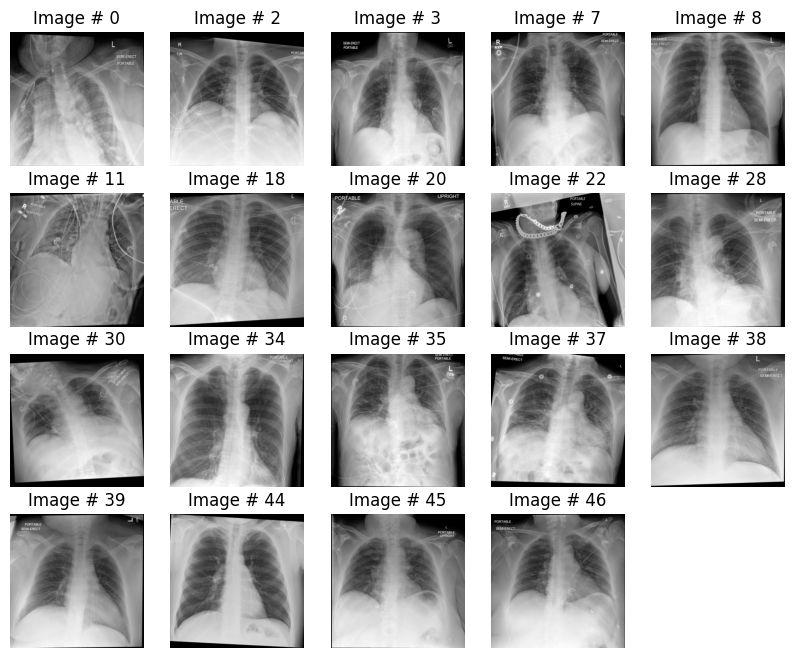

In [ ]:
show_imgs_preprocessed(imgs, img_list)

In [ ]:
def show_imgs_seq_preprocessed(starting_index=0):
  length = min(24, len(df) - starting_index)
  columns = 8
  rows = length // 8
  rows = rows if (8 * rows == length) else rows + 1
  imgs = df.iloc[starting_index:starting_index+length]['img'].tolist()
  fig = plt.figure(figsize=(columns * 2, rows * 2))
  for i in range(length):
    img = Process(imgs[i], 512, 512)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(img, 'gray')
    ax.title.set_text(f'Image # {starting_index + i}')
    ax.axis('off')

  plt.show()

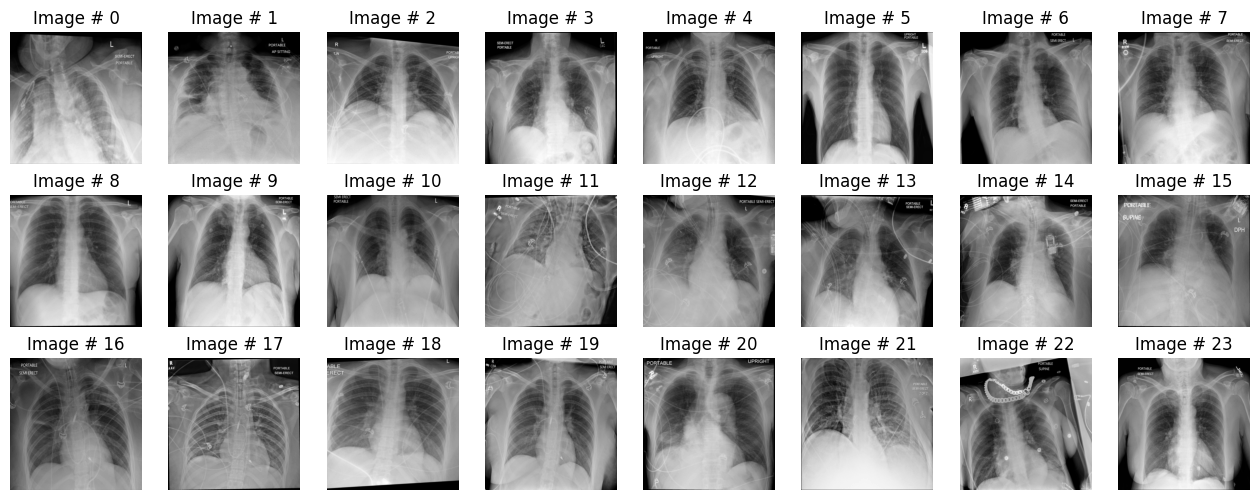

In [ ]:
show_imgs_seq_preprocessed()

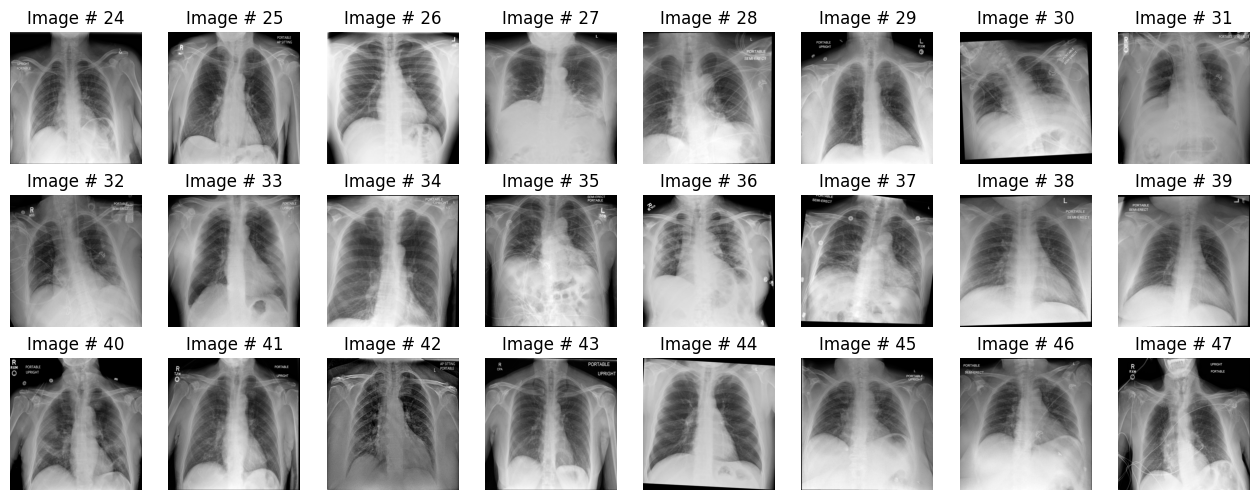

In [ ]:
show_imgs_seq_preprocessed(24)

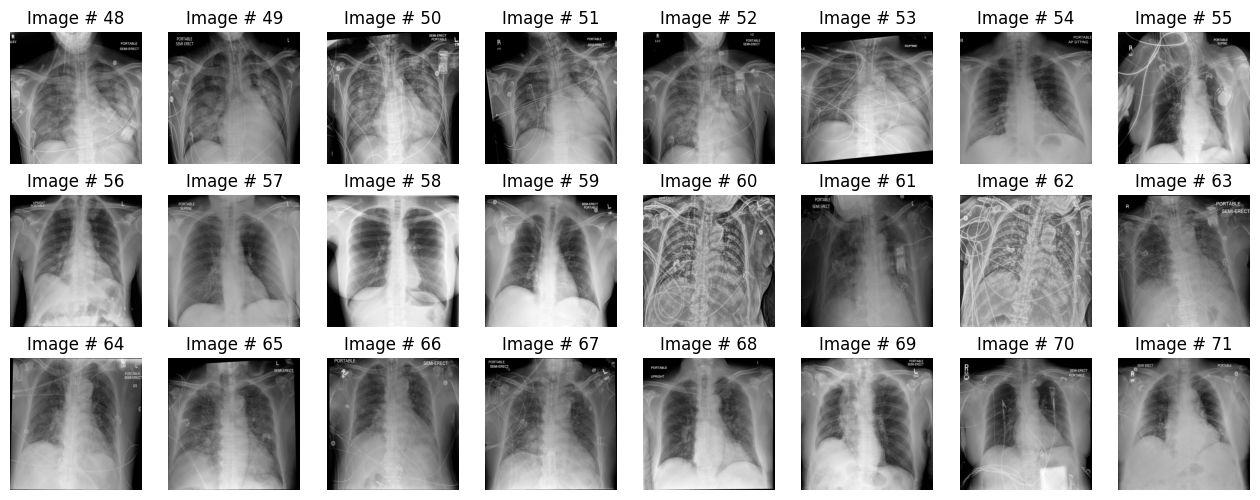

In [ ]:
show_imgs_seq_preprocessed(48)

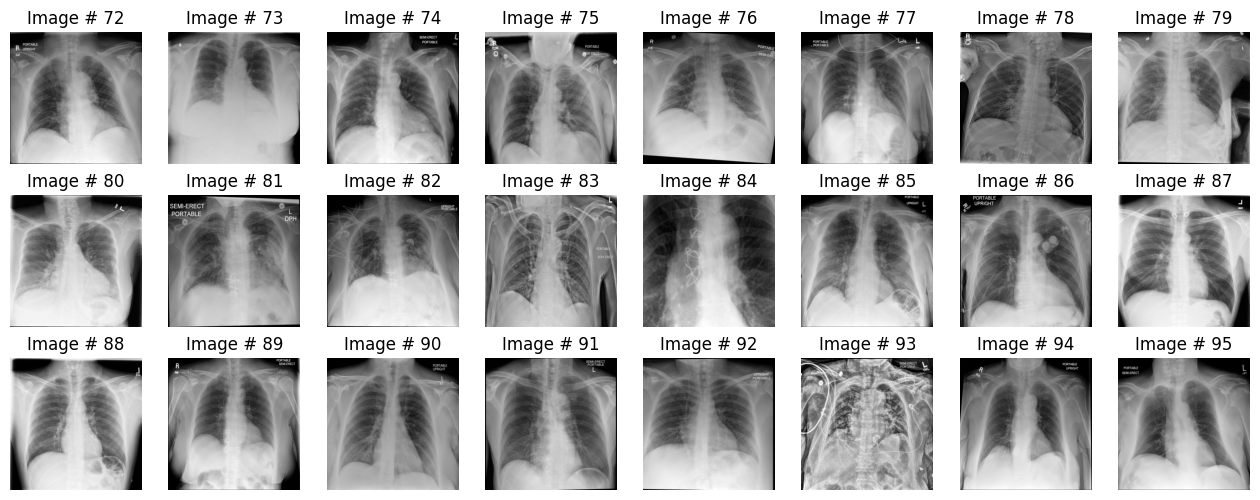

In [ ]:
show_imgs_seq_preprocessed(72)

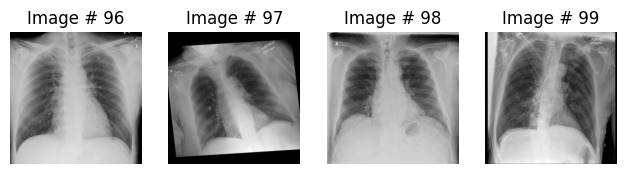

In [ ]:
show_imgs_seq_preprocessed(96)

In [ ]:
df['processed_img'] = df['img'].apply(Process)

In [ ]:
df.head()

,extent_right_numerical,density_right_numerical,extent_left_numerical,density_left_numerical,mRALE Score,img,processed_img
0,4,3,4,2,20,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,3,3,3,2,15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,1,1,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0,0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Medical Image/data/df_100.h5', 'wb') as f:
  dump(df, f)